In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2


### Load Processed Data

In [2]:
data = pd.read_pickle(r"C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\processed_data\final_train_data.pkl")

In [3]:
data.dtypes
data.shape

(1310, 2066)

In [4]:
# Extract structured data (already encoded & scaled)
# Extract first 18 columns, excluding columns 1, 6, and 7
structured_data = data.iloc[:, :18]  # First 18 columns
structured_data = structured_data.drop(columns=[data.columns[0], data.columns[5], data.columns[6]])
structured_data_scaled = structured_data.values


In [5]:
# Extract image features
image_features = data.iloc[:, 18:].values

In [6]:
image_features.shape

(1310, 2048)

In [7]:
# Extract labels
condition_labels = data['Condition'].values  # Binary classification target
amount_labels = data['Amount'].values.reshape(-1, 1)  # Regression target

In [8]:
print(np.isnan(image_features).sum(), np.isnan(structured_data_scaled).sum())

0 0


### Build Model

In [9]:
image_input = Input(shape=(image_features.shape[1],), name='image_input')
x = Dense(512, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(image_input)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x)

x = Dense(256, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(x)
x = BatchNormalization()(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.2)(x)

In [10]:
structured_input = Input(shape=(structured_data_scaled.shape[1],), name='structured_input')
y = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(structured_input)
y = BatchNormalization()(y)
y = LeakyReLU(negative_slope=0.1)(y)
y = Dropout(0.2)(y)

y = Dense(64, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(y)
y = BatchNormalization()(y)
y = LeakyReLU(negative_slope=0.1)(y)
y = Dropout(0.2)(y)


In [11]:
combined = Concatenate()([x, y])

z = Dense(128, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(combined)
z = BatchNormalization()(z)
z = LeakyReLU(negative_slope=0.1)(z)
z = Dropout(0.2)(z)

z = Dense(64, kernel_initializer='he_normal', kernel_regularizer=l2(0.00095))(z)
z = BatchNormalization()(z)
z = LeakyReLU(negative_slope=0.1)(z)
z = Dropout(0.2)(z)




In [12]:
# Output 1: Condition (Binary Classification)
condition_output = Dense(1, activation='sigmoid', name='condition_output')(z)

In [13]:
# Output 2: Amount (Regression)
amount_output = Dense(1, activation='linear', name='amount_output')(z)

In [14]:
# Define the Model
model = Model(inputs=[image_input, structured_input], outputs=[condition_output, amount_output])

In [15]:
# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.00095),
              loss={'condition_output': 'binary_crossentropy', 'amount_output':tf.keras.losses.Huber()},
              metrics={'condition_output': 'accuracy', 'amount_output': 'mse'})

In [23]:
#callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(r'C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models\best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

### Train Model

In [24]:
# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ structured_input (InputLayer) │ (None, 15)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │       1,049,088 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │           2,048 │ structured_input[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128)               │             512 │ dense_2[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 128)               │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ leaky_re_lu_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         131,328 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 64)                │           8,256 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256)               │           1,024 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64)                │             256 │ dense_3[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 256)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,729,800 (14.23 MB)

 Trainable params: 1,242,498 (4.74 MB)

 Non-trainable params: 2,304 (9.00 KB)

 Optimizer params: 2,484,998 (9.48 MB)

In [25]:
import time
import mlflow
import mlflow.tensorflow



In [26]:
# from mlflow.models.signature import ModelSignature
# from mlflow.types import Schema, ColSpec

# # Define the input and output schema explicitly
# input_schema = Schema([
#     ColSpec(type="array", type="float32", shape=(None, image_features.shape[1])),
#     ColSpec(type="array", type="float32", shape=(None, structured_data_scaled.shape[1]))
# ])

# output_schema = Schema([
#     ColSpec(type="array", dtype="float32", shape=(None, 1)),  # For condition_output
#     ColSpec(type="array", dtype="float32", shape=(None, 1))   # For amount_output
# ])

# # Create ModelSignature object
# signature = ModelSignature(inputs=input_schema, outputs=output_schema)


In [28]:
# Generate a unique model filename using the current timestamp
timestamp = int(time.time())
model_path = f'C:/Users/varsh/OneDrive/Desktop/notebook/Fast_Furious_Insured/api/models/model_{timestamp}.keras'  # Unique filename using timestamp

# Start a new MLflow run to track the model and metrics


In [29]:
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param('learning_rate', 0.00095)
    mlflow.log_param('epochs', 200)
    mlflow.log_param('batch_size', 16)

    # Train the model before saving/logging
    history = model.fit(
        [image_features, structured_data_scaled],  # Inputs
        {'condition_output': condition_labels, 'amount_output': amount_labels},  # Outputs
        epochs=200,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr, checkpoint],  # Callbacks
        verbose=1
    )

    # Log final training metrics (avoid KeyErrors)
    mlflow.log_metric('condition_output_accuracy', history.history.get('condition_output_accuracy', [None])[-1])
    mlflow.log_metric('amount_output_mse', history.history.get('amount_output_mse', [None])[-1])
    
    # Optionally log validation metrics
    mlflow.log_metric('val_condition_output_accuracy', history.history.get('val_condition_output_accuracy', [None])[-1])
    mlflow.log_metric('val_amount_output_mse', history.history.get('val_amount_output_mse', [None])[-1])

    # Save and log trained model with a unique filename
    model.save(model_path)
    mlflow.tensorflow.log_model(model, artifact_path="model")  # Log trained model

    print(f"Trained model saved and logged in MLflow at {model_path}")


Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - amount_output_loss: 0.5631 - amount_output_mse: 1.6996 - condition_output_accuracy: 0.5046 - condition_output_loss: 0.7817 - loss: 3.1993
Epoch 1: val_loss improved from inf to 2.31321, saving model to C:\Users\varsh\OneDrive\Desktop\notebook\Fast_Furious_Insured\api\models\best_model.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - amount_output_loss: 0.5615 - amount_output_mse: 1.6929 - condition_output_accuracy: 0.5072 - condition_output_loss: 0.7790 - loss: 3.1924 - val_amount_output_loss: 0.1594 - val_amount_output_mse: 0.3709 - val_condition_output_accuracy: 0.5458 - val_condition_output_loss: 0.6584 - val_loss: 2.3132 - learning_rate: 9.5000e-04
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - amount_output_loss: 0.2954 - amount_output_mse: 0.6842 - condition_output_accuracy: 0.9339 - condition_output_loss: 0.2663 - loss: 2.0256
Epoch 2: val_loss improved from 2.31321 to 1.75909, saving model to C:\Users\varsh\OneDrive\De

2025/02/14 13:22:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/02/14 13:22:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Trained model saved and logged in MLflow at C:/Users/varsh/OneDrive/Desktop/notebook/Fast_Furious_Insured/api/models/model_1739519356.keras


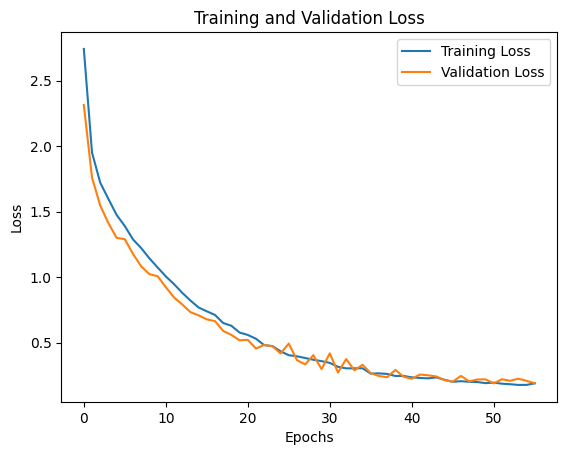

In [30]:
# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [31]:
# Print the final training and validation metrics and losses
print("Final Training and Validation Metrics:")

# Print the final training metrics
print("\nTraining Metrics:")
for metric, values in history.history.items():
    if 'val_' not in metric:  # Training metrics do not contain 'val_'
        print(f"{metric}: {values[-1]:.4f}")  # Print the last value for each training metric

# Print the final validation metrics
print("\nValidation Metrics:")
for metric, values in history.history.items():
    if 'val_' in metric:  # Validation metrics contain 'val_'
        print(f"{metric}: {values[-1]:.4f}")  # Print the last value for each validation metric


Final Training and Validation Metrics:

Training Metrics:
amount_output_loss: 0.0893
amount_output_mse: 0.1804
condition_output_accuracy: 1.0000
condition_output_loss: 0.0017
loss: 0.1895
learning_rate: 0.0001

Validation Metrics:
val_amount_output_loss: 0.0928
val_amount_output_mse: 0.1868
val_condition_output_accuracy: 1.0000
val_condition_output_loss: 0.0001
val_loss: 0.1902
